# Driver fatigue detection using eye condition classification CNN model

**Project Goal**:

Create a convolutional neural network model that classifies whether eyes are open or closed. Then use this model in a program that gives a warning message when a driver has their eyes closed for too long.

# Table of Contents
1. [CNN Model](#model_cnn)
    1. [Importing libraries and data](#import)
    2. [Preparing and augmenting data for model training](#przygotowanie)
    3. [Training models and assessing their effectiveness](#trenowanie)
2. [Testing the model on my own dataset](#testowanie)
    1. [My own dataset](#wlasny_zbior)
    2. [Testing the model](#testowanie_modelu)
3. [Testing the model on video sequences](#testowanie_wideo)
4. [Proposals for further project development](#rozwoj)

# CNN model <a name="model_cnn"></a>

## 1.1. Importing libraries and data <a name="import"></a>

In [58]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
import dlib
from imutils import face_utils
import time

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from keras.src.legacy.preprocessing.image import ImageDataGenerator

The model was trained with images from the Kaggle dataset: https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset. The dataset contains 726 images of closed eyes and the same number of images of open eyes.

Photo labels are assigned based on the folder the photo is in: 'open' or 'closed':

In [2]:
labels = os.listdir("../input/photos")

In [3]:
labels

['closed', 'open']

Sample photos from both categories:

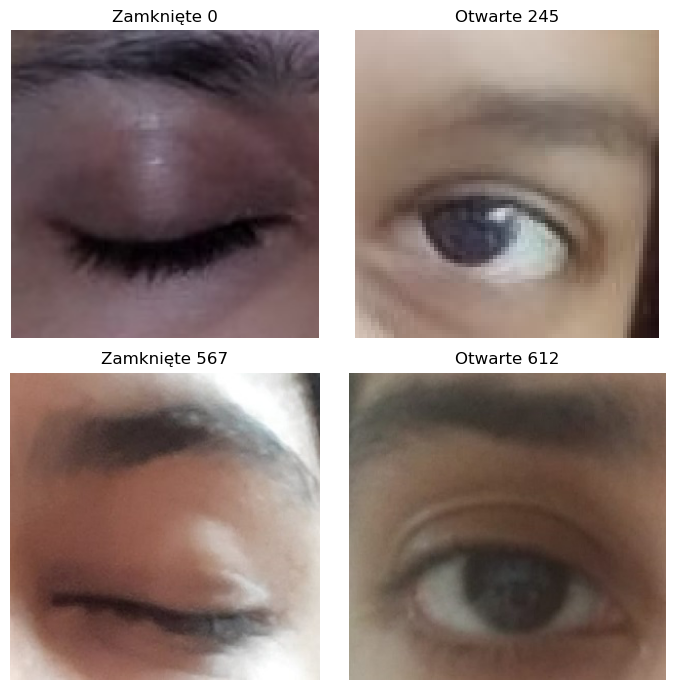

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

img0 = plt.imread("../input/photos/closed/_0.jpg")
axs[0, 0].imshow(img0)
axs[0, 0].set_title("Zamknięte 0")
axs[0, 0].axis('off')

img1 = plt.imread("../input/photos/open/_245.jpg")
axs[0, 1].imshow(img1)
axs[0, 1].set_title("Otwarte 245")
axs[0, 1].axis('off')

img2 = plt.imread("../input/photos/closed/_567.jpg")
axs[1, 0].imshow(img2)
axs[1, 0].set_title("Zamknięte 567")
axs[1, 0].axis('off')

img3 = plt.imread("../input/photos/open/_612.jpg")
axs[1, 1].imshow(img3)
axs[1, 1].set_title("Otwarte 612")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show() 

Photos shapes:

In [8]:
a = plt.imread("../input/photos/closed/_0.jpg")

In [9]:
a.shape

(145, 145, 3)

The 'get_data' function is used to load images from a specified directory and then process them into a form that can be used to train models. The images are scaled to a size of 145.

In [13]:
def get_data(dir_path="../input/photos/"):
    labels = ['closed', 'open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

## 1.2. Data preparation and augmentation for model training <a name="przygotowanie"></a>

Two lists 'X' are created to store images and 'y' for labels. They are filled iteratively by 'data_train':

In [14]:
data_train = get_data()
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

Then 'X' and 'y' are converted to numpy arrays, and 'X' is additionally transformed to dimensions corresponding to the format required by CNN models:

In [15]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Data Normalization: Converting the range of 'X' values ​​from 0-255 to 0-1.

In [16]:
X = X / 255.0

In [17]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [18]:
y = np.array(y)

The data is split into training and testing sets, where 30% of the data is used as the test set. The setting 'stratify=y' is to ensure that both sets have similar proportions of classes.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

Labels are transformed to a categorical format, which is required for the later use of the 'binary-crossentropy' loss function.

In [20]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

The use of data augmentation is intended to help increase the diversity of data through random modifications of images (changing the scale, mirroring, rotation), while the creation of data generators allows for more efficient loading and processing of data during model training.

In [21]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## 1.3. Training Models and Evaluating Their Performance <a name="trenowanie"></a>

### Model 1

This model contains **two convolutional layers** with **32 and 64 filters** and ReLU activation function, combined with MaxPooling layers. Flatten layer transforms data into a vector, which is processed by **dense layer with 128 neurons** and dropout 0.5, to reduce the risk of overfitting. The last Dense layer with two outputs and softmax activation function is used to classify images into two classes.

In [54]:
input_shape = (145, 145, 3)
num_classes = 2

model_1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_1.summary()

C:\Users\sonia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       9,470,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,489,730 (36.20 MB)

 Trainable params: 9,489,730 (36.20 MB)

 Non-trainable params: 0 (0.00 B)

The training process of this model consists of running the entire training dataset through the model 50 times, this data is divided into smaller groups 'batches', where each 'batch' contains 32 examples. Test data is used for validation after each 'epoch', which allows for monitoring and evaluating the model's performance.

In [55]:
history_1 = model_1.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.6211 - loss: 1.1057 - val_accuracy: 0.8601 - val_loss: 0.2915
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9054 - loss: 0.2467 - val_accuracy: 0.9220 - val_loss: 0.1813
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9387 - loss: 0.1645 - val_accuracy: 0.9450 - val_loss: 0.1474
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.9430 - loss: 0.1453 - val_accuracy: 0.9564 - val_loss: 0.1293
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9734 - loss: 0.0771 - val_accuracy: 0.9427 - val_loss: 0.1680
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.9671 - loss: 0.0976 - val_accuracy: 0.9541 - val_loss: 0.1485
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9725 - loss: 0.0768 - val_accuracy: 0.9587 - val_loss: 0.1420
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.9730 - loss: 0.0733 - val_accuracy: 0.

**Accuracy and Loss Charts**

In [40]:
def plot_training_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "b", label="training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "b", label="training loss")
    plt.plot(epochs, val_loss, "r", label="validation loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()

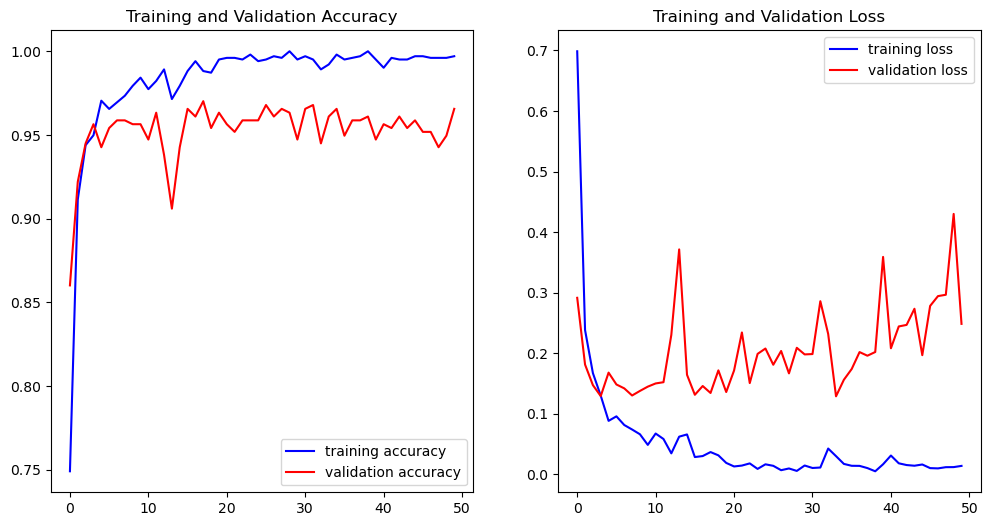

In [64]:
plot_training_history(history_1)

The training accuracy is close to 100%, while the validation accuracy is around 95%, which is a good result, but may suggest that the model may be slightly overfitted. The training loss gradually decreases, reaching a low level, while the validation loss oscillates around 0.2.

**Classification Report and Support Functions**

In [41]:
def prepare_image(filepath, IMG_SIZE=145):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0

In [42]:
def predict_state(filepath, model):
    prepared_image = prepare_image(filepath)
    prediction = model.predict(prepared_image)
    return prediction[0][0] 

In [37]:
predictions = model_1.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [65]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.96      0.99      0.97       218
      closed       0.99      0.95      0.97       218

    accuracy                           0.97       436
   macro avg       0.97      0.97      0.97       436
weighted avg       0.97      0.97      0.97       436



Model 1 achieves high accuracy (97%) and very good recall for the 'closed' class (95%). Recall for the 'closed' class means that the model correctly identifies 95% of closed eyes, which is a good result, especially for an application where detecting closed eyes is crucial.

### Model 2

This model contains **four convolutional layers** with increasing number of filters (**32, 64, 128, 128**), each of them follows MaxPooling operation which helps in dimensionality reduction while preserving essential features. **Dense layers with 512 units** and Dropout (0.5) minimize the risk of overfitting and softmax classifies images into two classes.

In [66]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()


C:\Users\sonia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,634 (13.17 MB)

 Trainable params: 3,453,634 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

The process and parameters for training this model are the same as the previous one.

In [71]:
history_2 = model_2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 1.0000 - loss: 2.5797e-04 - val_accuracy: 0.9725 - val_loss: 0.4224
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 1.0000 - loss: 1.5669e-04 - val_accuracy: 0.9702 - val_loss: 0.5195
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 1.0000 - loss: 5.7330e-05 - val_accuracy: 0.9771 - val_loss: 0.4398
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 1.0000 - loss: 3.7097e-05 - val_accuracy: 0.9771 - val_loss: 0.4450
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 1.0000 - loss: 5.5114e-05 - val_accuracy: 0.9748 - val_loss: 0.4613
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 1.0000 - loss: 2.2134e-05 - val_accuracy: 0.9748 - val_loss: 0.4640
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 1.0000 - loss: 2.4339e-05 - val_accuracy: 0.9748 - val_loss: 0.4605
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 1.0000 -

Epoch 50/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 1.0000 - loss: 1.0240e-06 - val_accuracy: 0.9771 - val_loss: 0.5104


**Accuracy and Loss Charts**

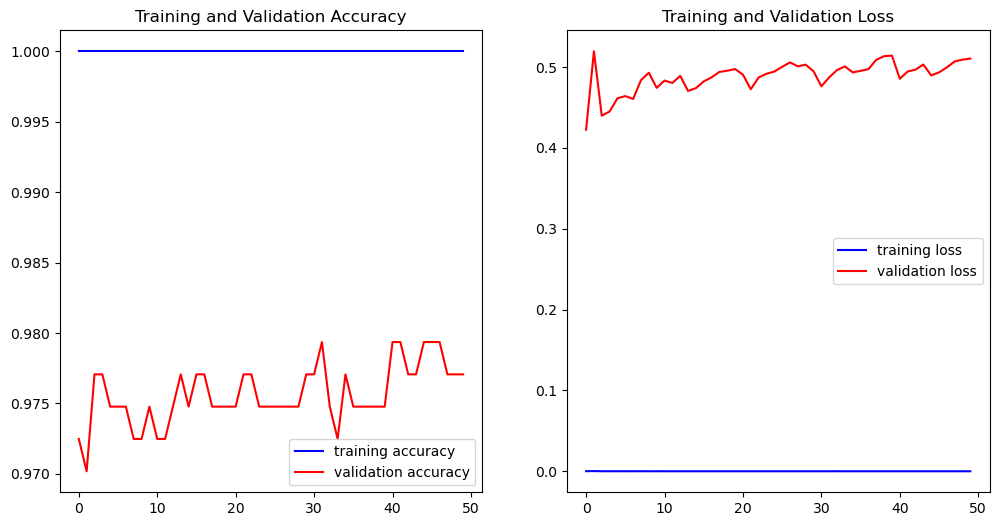

In [72]:
plot_training_history(history_2)

The training accuracy after the rapid growth reaches 100%, which suggests that the model is very effective in recognizing the features of the training data. The validation accuracy after the growth remains at around 97.5%. The training loss remains low throughout the training process, so the model effectively minimizes errors on the training data. The validation loss is more variable, which suggests that there may be more difficult features in the data to learn.

**Classification Report**

In [73]:
predictions = model_2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


In [74]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.97      0.99      0.98       218
      closed       0.99      0.97      0.98       218

    accuracy                           0.98       436
   macro avg       0.98      0.98      0.98       436
weighted avg       0.98      0.98      0.98       436



Recall for the 'closed' class is 98%, meaning that the model correctly identifies 98% of closed eye cases. In the context of monitoring driver attention, this is a key metric because high recall for closed eyes ensures that the model rarely misses cases where the eyes are closed, which can be an indicator of fatigue or sleepiness. The overall accuracy of the model is 99%, meaning that the model correctly classifies 99% of all cases in the test set.

The best model should be **the smallest and most effective**, so based on the results of the two previous models I decided to create an intermediate variant with **3 layers**.

### Model 3

To speed up the model, I reduced the **Dense layer size** and the number of layers.

In [75]:
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

C:\Users\sonia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,938 (16.36 MB)

 Trainable params: 4,287,938 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
history_3 = model_3.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9979 - loss: 0.0096 - val_accuracy: 0.9633 - val_loss: 0.2583
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9679 - val_loss: 0.2361
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9679 - val_loss: 0.2468
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 1.0000 - loss: 4.1651e-04 - val_accuracy: 0.9679 - val_loss: 0.2552
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9702 - val_loss: 0.1714
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.9988 - loss: 0.0042 - val_accuracy: 0.9656 - val_loss: 0.2718
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.9959 - loss: 0.0219 - val_accuracy: 0.9702 - val_loss: 0.1523
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.9742 - loss: 0.0567 - val_accuracy

**Accuracy and Loss Charts**

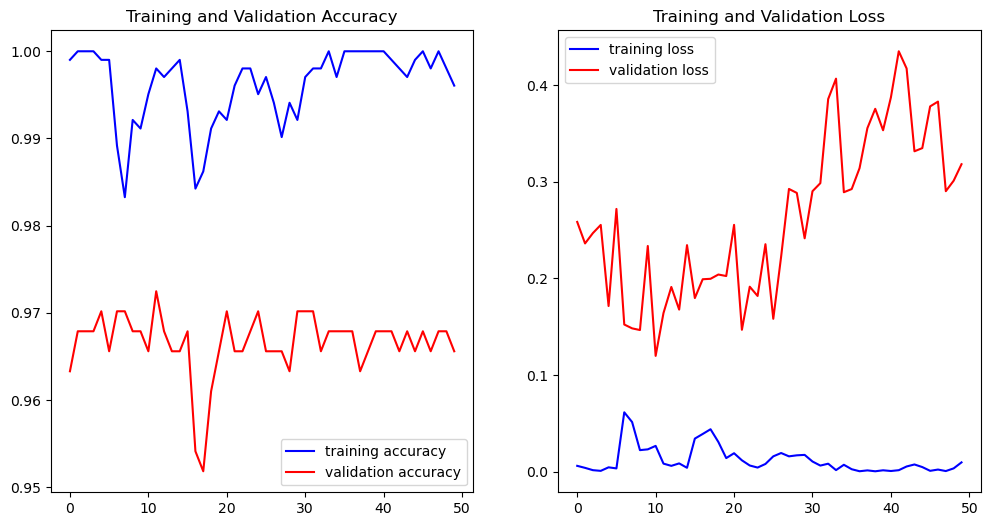

In [81]:
plot_training_history(history_3)

**Classification Report**

In [82]:
predictions = model_3.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [83]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.95      0.98      0.97       218
      closed       0.98      0.95      0.97       218

    accuracy                           0.97       436
   macro avg       0.97      0.97      0.97       436
weighted avg       0.97      0.97      0.97       436



Model 3 achieves lower recall scores for the 'closed' class compared to the previous model, but is also smaller, so it is more useful for the purposes of this project. In order to achieve better results in Model 4, I increased the size of the Dense layer.

### Model 4

This model contains **three convolutional layers** with increasing number of filters (**32, 64, 128**), each of them follows MaxPooling operation which helps in dimensionality reduction while preserving important features. **Dense layer with 256 units** and Dropout (0.5) minimizes the risk of overfitting and softmax classifies images into two classes.

In [22]:
model_4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

C:\Users\sonia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_4 = model_4.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9967 - loss: 0.0078 - val_accuracy: 0.9656 - val_loss: 0.2982
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9925 - loss: 0.0163 - val_accuracy: 0.9679 - val_loss: 0.2663
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9949 - loss: 0.0075 - val_accuracy: 0.9633 - val_loss: 0.4101
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 1.0000 - loss: 9.9876e-04 - val_accuracy: 0.9656 - val_loss: 0.3858
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9702 - val_loss: 0.3938
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9725 - val_loss: 0.3622
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9656 - val_loss: 0.4210
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy

**Accuracy and Loss Charts**

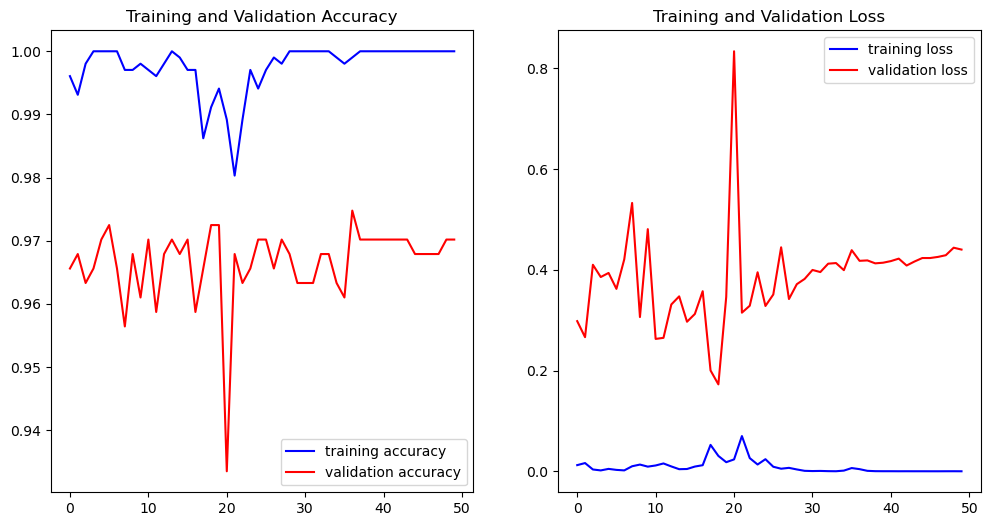

In [48]:
plot_training_history(history_4)

The training accuracy is very high, hovering around 99%. This indicates that the model learns the training data effectively, with one drop, possibly due to a problematic case of the training data. The validation accuracy is less stable and generally lower, which may indicate a sensitive response to new data. The training loss is low and stable, while the validation loss shows significant variability and several distinct peaks, which may also indicate subtle issues with model instability during validation.

**Classification Report**

In [49]:
predictions = model_4.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [50]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.96      0.99      0.97       218
      closed       0.99      0.95      0.97       218

    accuracy                           0.97       436
   macro avg       0.97      0.97      0.97       436
weighted avg       0.97      0.97      0.97       436



Model 4 has the same accuracy (97%) and recall for the 'closed' class as Model 3. However, recall for the 'open' class is higher (99%). Model 4 also has fewer layers than Model 2, which has the best results, so it may be better suited for faster performance in eye classification from video sequences.

### Model Comparison

I compared the models in the form of a table containing the most important results of model training, i.e. recall for the 'closed' class and accuracy.

In [52]:
def get_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'], output_dict=True)
    return report['accuracy'], report['closed']['recall']

In [84]:
accuracy_1, recall_closed_1 = get_metrics(model_1, X_test, y_test)
accuracy_2, recall_closed_2 = get_metrics(model_2, X_test, y_test)
accuracy_3, recall_closed_3 = get_metrics(model_3, X_test, y_test)
accuracy_4, recall_closed_4 = get_metrics(model_4, X_test, y_test)

results_df = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
    "Recall (closed)": [recall_closed_1, recall_closed_2, recall_closed_3, recall_closed_4]
})

results_df

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


,Model,Accuracy,Recall (closed)
0,Model 1,0.965596,0.958716
1,Model 2,0.977064,0.967890
2,Model 3,0.965596,0.949541
3,Model 4,0.970183,0.954128


The best parameters, taking into account the model size and classification results, are shown by model 4. The model's effectiveness in classifying open and closed eyes is accurate, with very high precision and reproduction, and the number of layers is the most optimal among the tested solutions. Therefore, this model is saved and used in the further implementation of the project.

In [87]:
model_4.save("model_4.h5")

## 2.Testing the model on my own dataset <a name="testowanie"></a>

## 2.1. My own dataset <a name="wlasny_zbior"></a>

To test the chosen model, I created my own dataset. I recorded 10 people who imitated the behavior of a tired driver and closed their eyes for longer periods of time. Then I wrote a script that saved every second of video frames as photos to a selected folder.

*In order to maintain the privacy of people involved in my project, the dataset I created is not shown or attached to the remote repository*

In [38]:
folder_open = "../output/captured_frames/open"
folder_closed = "../output/captured_frames/closed"

num_files_open = len([name for name in os.listdir(folder_open) if os.path.isfile(os.path.join(folder_open, name))])
print(f"Liczba zdjęć w folderze 'open': {num_files_open}")

num_files_closed = len([name for name in os.listdir(folder_closed) if os.path.isfile(os.path.join(folder_closed, name))])
print(f"Liczba zdjęć w folderze 'closed': {num_files_closed}")

Liczba zdjęć w folderze 'open': 467
Liczba zdjęć w folderze 'closed': 438


In [ ]:
def capture_frames(video_path, output_folder, interval_seconds):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Can't open video stream or file.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval_seconds)

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            img_path = os.path.join(output_folder, f"frame_{saved_count}.jpg")
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(image)
            pil_image.save(img_path)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"{saved_count} photos saved.")

video_path = 'path_to_video'
output_folder = 'path_to_output_folder'
interval_seconds = 1

capture_frames(video_path, output_folder, interval_seconds)

I divided the frames cut from the films into those with open or closed eyes and placed them in appropriately named folders.

In [25]:
labels_2 = os.listdir("../output/captured_frames")
labels

['closed', 'open']

In [26]:
get_data('../output/captured_frames')

[[array([[[148, 179, 182],
          [155, 186, 189],
          [151, 182, 185],
          ...,
          [109, 123, 122],
          [109, 123, 122],
          [109, 123, 122]],
  
         [[184, 215, 218],
          [183, 213, 216],
          [175, 206, 209],
          ...,
          [109, 123, 122],
          [109, 123, 122],
          [109, 123, 122]],
  
         [[135, 166, 169],
          [123, 154, 157],
          [148, 179, 182],
          ...,
          [108, 125, 122],
          [112, 126, 124],
          [109, 123, 122]],
  
         ...,
  
         [[ 35,  62,  82],
          [ 34,  61,  81],
          [ 33,  62,  77],
          ...,
          [ 12,  59, 104],
          [ 12,  57, 108],
          [ 14,  56, 109]],
  
         [[ 35,  62,  82],
          [ 34,  61,  81],
          [ 32,  61,  77],
          ...,
          [ 12,  55, 100],
          [  8,  54, 101],
          [ 12,  56, 105]],
  
         [[ 34,  61,  81],
          [ 33,  58,  78],
          [ 36,  59,  74

## 2.2. Testing the model <a name="testowanie_modelu"></a>

I created functions to detect eyes and classify their state. The **add_margin_to_eye** function is used to expand the detection rectangle that contains the eye by adding margins to it. This allows for a larger area around the eye to be included. The **classify_eye_state** function is used to classify the eye state (open/closed) based on a given image fragment (ROI - Region of Interest). It takes the ROI image, processes it, and applies a predictive model to assess the eye state.

In [56]:
def add_margin_to_eye(x, y, w, h, width, height, margin_w=0.6, upper_margin_h=2.5, lower_margin_h=0.7):
    x_margin = int(w * margin_w)
    upper_y_margin = int(h * upper_margin_h)
    lower_y_margin = int(h * lower_margin_h)

    x_new = max(x - x_margin, 0)
    y_new = max(y - upper_y_margin, 0)
    x_end = min(x + w + x_margin, width)
    y_end = min(y + h + lower_y_margin, height)

    return (x_new, y_new, x_end - x_new, y_end - y_new)

def classify_eye_state(roi, model):
    roi_resized = cv2.resize(roi, (145, 145))
    roi_gray = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2GRAY)
    roi_rgb = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
    roi_normalized = roi_rgb / 255.0
    roi_expanded = np.expand_dims(roi_normalized, axis=0)
    prediction = model.predict(roi_expanded)
    return prediction[0]

I then wrote code to test the model on my dataset. It uses the dlib library to detect faces and determine key points on the face, and then uses the model to predict the eye state for each detected eye. The output is a list of predictions and file names, which are then analyzed to assess the model's accuracy by comparing it to the expected labels.

In [61]:
def process_folder(folder_path, expected_label, model):
    predictions = []
    filenames = []
    detector = dlib.get_frontal_face_detector()

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faceRects = detector(gray, 1)

        for (i, faceRect) in enumerate(faceRects):
            shape = predictor(gray, faceRect)
            shape_np = face_utils.shape_to_np(shape)

            for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
                if name in ["left_eye", "right_eye"]:
                    (x, y, w, h) = cv2.boundingRect(np.array([shape_np[i:j]]))
                    (x, y, w, h) = add_margin_to_eye(x, y, w, h, img.shape[1], img.shape[0])

                    roi = img[y:y + h, x:x + w]
                    eye_state_prediction = classify_eye_state(roi, model)

                    eye_state = 1 if eye_state_prediction[0] > 0.5 else 0
                    predictions.append(eye_state)
                    filenames.append(image_name)

    return predictions, filenames

predictor = dlib.shape_predictor('..\shape_predictor_68_face_landmarks.dat')

eye_state_model = load_model('model_4.h5')

open_folder = r'..\output\captured_frames\open'
closed_folder = r'..\output\captured_frames\closed'

open_predictions, open_filenames = process_folder(open_folder, 0, eye_state_model)
closed_predictions, closed_filenames = process_folder(closed_folder, 1, eye_state_model)

predictions = open_predictions + closed_predictions
true_labels = [0] * len(open_predictions) + [1] * len(closed_predictions)
filenames = open_filenames + closed_filenames


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [63]:
print(classification_report(true_labels, predictions, target_names=['Open', 'Closed']))

              precision    recall  f1-score   support

        Open       0.91      0.95      0.93       934
      Closed       0.95      0.90      0.92       868

    accuracy                           0.93      1802
   macro avg       0.93      0.93      0.93      1802
weighted avg       0.93      0.93      0.93      1802



### Conclusions
Recall for the 'Closed' class, the model's ability to correctly identify truly closed eyes, is 0.90. This is a key metric in the context of fatigue detection, as it is important that the system does not miss any cases where the driver's eyes are closed. Although a value of 90% is quite high, in ideal conditions, you would want to maximize this value to minimize the risk of missing a tired driver. The overall system accuracy is 0.93, meaning that 93% of the model's predictions are correct. This is a good value, indicating that the model is generally good at distinguishing between open and closed eyes.

## 3. Testing the model on a video sequence <a name="testowanie_wideo"></a>

The final stage of the project was to use the created model in a situation simulating observing a driver in a car using an image captured by a laptop camera or previously recorded video.

I wrote a code to monitor the user's eye state in real time. It uses the OpenCV library to read the video stream from the camera/video, and then analyzes each frame every 1 second to detect and assess the eye state (open or closed) using an eye state classification model.

In each frame checked, the image is converted to grayscale, and then dlib methods are used to detect faces and key points that allow for eye localization. After eye regions are identified and framed using previously implemented functions, they are passed to the classify_eye_state function, which predicts whether the eye is open or closed.

The system also monitors the duration of eye closure and if the eye remains closed for too long, a text alarm is generated to wake up, which is intended to prevent accidents caused by driver fatigue. The user can interrupt the program by pressing the 'q' key.

In [ ]:
eye_state_model = load_model('model_4.h5')
detector = dlib.get_frontal_face_detector()

video_path = r'video_path'
cap = cv2.VideoCapture(video_path)
# cap = cv2.VideoCapture(0) # webcam

frame_counter = 0
check_interval = 30

closed_eye_counter = 0
closed_eye_threshold = 6
warning_display_time = 3
warning_end_time = None

window_width = 800
window_height = 480

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (window_width, window_height))

    frame_counter += 1

    if frame_counter % check_interval == 0:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faceRects = detector(gray, 1)

        for (i, faceRect) in enumerate(faceRects):
            shape = predictor(gray, faceRect)
            shape_np = face_utils.shape_to_np(shape)

            for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
                if name in ["left_eye", "right_eye"]:
                    (x, y, w, h) = cv2.boundingRect(np.array([shape_np[i:j]]))
                    (x, y, w, h) = add_margin_to_eye(x, y, w, h, frame.shape[1], frame.shape[0])

                    roi = frame[y:y + h, x:x + w]
                    eye_state_prediction = classify_eye_state(roi, eye_state_model)

                    if isinstance(eye_state_prediction, np.ndarray):
                        eye_state_probability = eye_state_prediction[0]
                    else:
                        eye_state_probability = eye_state_prediction

                    eye_state = "Open" if eye_state_probability < 0.5 else "Closed"
                    print(f"{name} state: {eye_state}")

                    if eye_state == "Closed":
                        closed_eye_counter += 1
                    else:
                        closed_eye_counter = 0

                    if closed_eye_counter >= closed_eye_threshold:
                        warning_end_time = time.time() + warning_display_time
                        closed_eye_counter = 0

    if warning_end_time and time.time() < warning_end_time:
        cv2.putText(frame, 'WARNING: Wake up!', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)

    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 4. Proposals for further development of the project <a name="rozwoj"></a>

* **Eye-point distance calculations**: Integrating this model with eye-point distance calculations could enable faster and more accurate detection of eye closure.

* **Improving recall for the 'Closed' class**: To enhance the project's quality, efforts should focus on improving recall for the 'Closed' class. This could be achieved by further training the model on a larger dataset or by testing alternative neural network architectures that may be more effective for this task. Additionally, integrating this model with eye-point distance calculations could enable faster and more accurate detection of eye closure.

* **Reducing the number of false alarms**: While safety is a priority and a higher number of alerts (even false ones) is acceptable, measures can be taken to minimize false alarms, making the system as user-friendly as possible.

* **Enhancing the warning alert**: To regain the driver's attention, a simultaneous warning sound can be added alongside the text alert.